# AI-Powered URL Phishing Detection System
# Deep Random Forest Classifier for Chatbot

## Steup and Imports

In [90]:
!pip install python-whois python-Levenshtein dnspython tldextract beautifulsoup4 requests pyOpenSSL tqdm

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import json
import os
import re
import requests
import socket
from urllib.parse import urlparse
from datetime import datetime
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import joblib
import whois
import Levenshtein
import dns.resolver
import tldextract
import concurrent.futures
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

### Mount Google Drive

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration and Logging

### Set up logging

In [93]:
log_data = []

def log_event(event_type, message, metadata=None):
    """Log events for research documentation"""
    log_entry = {
        "timestamp": datetime.now().isoformat(),
        "event_type": event_type,
        "message": message,
        "metadata": metadata or {}
    }
    log_data.append(log_entry)
    print(f"[{log_entry['timestamp']}] {event_type}: {message}")

### Define paths

In [94]:
BASE_PATH = '/content/drive/MyDrive/PUSL3190'
RAW_DATA_PATH = f'{BASE_PATH}/data/raw/phishing_site_urls.csv'
PROCESSED_DATA_PATH = f'{BASE_PATH}/data/processed/chatbot/chatbot_features.csv'
MODEL_OUTPUT_PATH = f'{BASE_PATH}/models/chatbot/chatbot_model.pkl'
SCALER_OUTPUT_PATH = f'{BASE_PATH}/models/chatbot/chatbot_scaler.pkl'
METADATA_OUTPUT_PATH = f'{BASE_PATH}/models/chatbot/chatbot_metadata.json'
FEATURES_OUTPUT_PATH = f'{BASE_PATH}/models/chatbot/chatbot_features.json'
LOG_OUTPUT_PATH = f'{BASE_PATH}/logs/chatbot_training_log.json'

### Create directories if they don't exist

In [95]:
os.makedirs(f'{BASE_PATH}/data/processed', exist_ok=True)
os.makedirs(f'{BASE_PATH}/models/gradient_boosting_model', exist_ok=True)
os.makedirs(f'{BASE_PATH}/logs', exist_ok=True)

## 1. Load and explore the dataset

### Whitelist for legitimate HTTP URLs

In [96]:
HTTP_WHITELIST = ['example.com', 'info.cern.ch', 'localhost']

### Load dataset

In [97]:
log_event("DATA_LOADING", "Loading dataset")
start_time = time.time()

[2025-04-29T19:06:39.757252] DATA_LOADING: Loading dataset


In [98]:
try:
    df = pd.read_csv(RAW_DATA_PATH)
    # Ensure class column is properly named and has numeric values
    if 'label' in df.columns:
        df = df.rename(columns={'label': 'class'})

    if df['class'].dtype == 'object':
        df['class'] = df['class'].map({'good': 0, 'bad': 1, 'legitimate': 0, 'phishing': 1})

    print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"Class distribution: {df['class'].value_counts().to_dict()}")

    log_event("DATA_LOADED", f"Dataset loaded with shape {df.shape}")
except Exception as e:
    log_event("ERROR", f"Failed to load dataset: {str(e)}")
    raise

Dataset loaded with 4000 rows and 2 columns
Class distribution: {1: 2000, 0: 2000}
[2025-04-29T19:06:39.796386] DATA_LOADED: Dataset loaded with shape (4000, 2)


In [99]:
loading_time = time.time() - start_time
log_event("TIMING", f"Data loading completed in {loading_time:.2f} seconds")

[2025-04-29T19:06:39.818009] TIMING: Data loading completed in 0.06 seconds


### Display basic information

In [100]:
print("Dataset Information:")
print(f"Total samples: {df.shape[0]}")
print(f"Features: {df.shape[1]}")
print("\nData Types:")
print(df.dtypes)
print("\nClass Distribution:")
print(df['class'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

Dataset Information:
Total samples: 4000
Features: 2

Data Types:
URL      object
class     int64
dtype: object

Class Distribution:
class
1    2000
0    2000
Name: count, dtype: int64

First 5 rows:
                                            URL  class
0  https://start-support-tizer.gitbook.io/en-us      1
1       https://iieudsjwasndjfkdjdd.weebly.com/      1
2           https://0x-turbos.pages.dev/wallets      1
3                   https://shbox.top/yecunoeu/      1
4            https://sparkflrdrops.xyz/clm.html      1


## 2. Feature Extraction Functions

In [101]:
log_event("FEATURE_EXTRACTION_FUNCTIONS", "Extracting functions for chatbot deep analysis")
start_time = time.time()

[2025-04-29T19:06:39.881702] FEATURE_EXTRACTION_FUNCTIONS: Extracting functions for chatbot deep analysis


Extract comprehensive features for deep analysis in the chatbot based on the specified list:
  - UsingIP
  - uses_http
  - LegitimacyScore
  - PrefixSuffix-
  - WebsiteTraffic
  - DNSRecording
  - PageRank
  - GoogleIndex
  - SubDomains
  - DomainLength
  - LinksPointingToPage
  - StatsReport
  - DomainRegLen
  - RequestURL
  - AbnormalURL
  - Symbol@
  - IsTyposquatting
  - BrandInSubdomain
  - UsingIP
  - AgeofDomain

### URL Parsing

In [102]:
def get_domain(url):
    """Extract domain from URL"""
    try:
        extracted = tldextract.extract(url)
        domain = f"{extracted.domain}.{extracted.suffix}"
        if extracted.subdomain:
            full_domain = f"{extracted.subdomain}.{domain}"
        else:
            full_domain = domain
        return domain, full_domain
    except:
        return None, None

### WHOIS Information

In [103]:
def get_domain_info(domain):
    """Get domain registration info using WHOIS"""
    try:
        w = whois.whois(domain)

        # Get creation date
        creation_date = w.creation_date
        if isinstance(creation_date, list):
            creation_date = creation_date[0]

        # Get expiration date
        expiration_date = w.expiration_date
        if isinstance(expiration_date, list):
            expiration_date = expiration_date[0]

        # Calculate age in days
        if creation_date:
            domain_age = (datetime.now() - creation_date).days
        else:
            domain_age = -1

        # Calculate registration length in days
        if creation_date and expiration_date:
            reg_len = (expiration_date - creation_date).days
        else:
            reg_len = -1

        return {
            'domain_age': domain_age,
            'registration_length': reg_len
        }
    except Exception as e:
        return {
            'domain_age': -1,
            'registration_length': -1
        }

### DNS Records

In [104]:
def get_dns_records(domain):
    """Check if domain has proper DNS records"""
    records = {
        'has_a': False,
        'has_mx': False,
        'has_ns': False,
        'total_records': 0
    }

    try:
        # A record
        try:
            answers = dns.resolver.resolve(domain, 'A')
            records['has_a'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        # MX record
        try:
            answers = dns.resolver.resolve(domain, 'MX')
            records['has_mx'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        # NS record
        try:
            answers = dns.resolver.resolve(domain, 'NS')
            records['has_ns'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        return records
    except Exception as e:
        return records

### HTML Content Analysis

In [105]:
def get_default_html_features():
    return {
        'external_favicon': False,
        'form_action_external': False,
        'external_scripts': 0,
        'external_links': 0,
        'internal_links': 1  # Default to 1 to avoid division by zero
    }

In [106]:
def analyze_html_content(url):
    """Simplified HTML content analysis focusing on key suspicious patterns"""
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'
        }
        response = requests.get(url, headers=headers, timeout=3)

        if response.status_code != 200:
            return get_default_html_features()

        soup = BeautifulSoup(response.text, 'html.parser')
        domain, full_domain = get_domain(url)

        # Favicon analysis
        favicon = soup.find('link', rel=lambda r: r and 'icon' in r.lower())
        external_favicon = False
        if favicon and favicon.get('href'):
            favicon_url = favicon['href']
            if favicon_url.startswith('http'):
                favicon_domain = get_domain(favicon_url)[0]
                external_favicon = favicon_domain != domain

        # Forms analysis
        forms = soup.find_all('form')
        form_action_external = False
        for form in forms:
            action = form.get('action', '')
            if action and action.startswith('http'):
                action_domain = get_domain(action)[0]
                if action_domain != domain:
                    form_action_external = True
                    break

        # Script analysis
        scripts = soup.find_all('script', src=True)
        external_scripts = 0
        for script in scripts:
            if script['src'].startswith('http'):
                script_domain = get_domain(script['src'])[0]
                if script_domain != domain:
                    external_scripts += 1

        # Link analysis
        links = soup.find_all('a', href=True)
        external_links = 0
        internal_links = 0

        for link in links:
            href = link['href'].lower()
            if href.startswith('http'):
                link_domain = get_domain(href)[0]
                if link_domain != domain:
                    external_links += 1
                else:
                    internal_links += 1
            else:
                internal_links += 1

        return {
            'external_favicon': external_favicon,
            'form_action_external': form_action_external,
            'external_scripts': external_scripts,
            'external_links': external_links,
            'internal_links': internal_links
        }
    except Exception as e:
        return get_default_html_features()

### Dictionary for popular brands for typosquatting detection

In [107]:
def get_popular_brand_domains():
    return {
        # Tech companies
        'google': ['google.com', 'gmail.com', 'youtube.com'],
        'microsoft': ['microsoft.com', 'office.com', 'outlook.com'],
        'apple': ['apple.com', 'icloud.com'],
        'amazon': ['amazon.com', 'aws.amazon.com'],
        'meta': ['facebook.com', 'instagram.com', 'whatsapp.com'],
        'paypal': ['paypal.com', 'paypal.me'],

        # Financial
        'bank': ['chase.com', 'bankofamerica.com', 'wellsfargo.com', 'citibank.com'],
        'investment': ['fidelity.com', 'vanguard.com', 'schwab.com'],

        # Email providers
        'mail': ['yahoo.com', 'hotmail.com', 'aol.com', 'protonmail.com'],

        # Social media
        'social': ['twitter.com', 'linkedin.com', 'pinterest.com', 'reddit.com'],

        # Education
        'education': ['coursera.org', 'udemy.com', 'edx.org']
    }

### Typosquatting Detection

In [108]:
def detect_typosquatting(domain):
    try:
        brand_domains = []
        for domains in get_popular_brand_domains().values():
            brand_domains.extend(domains)

        result = {
            'is_typosquatting': False,
            'impersonated_domain': None,
            'edit_distance': None
        }

        if len(domain) < 4:
            return result

        domain = domain.lower()
        domain_base = domain.split('.')[0]

        # Quick character substitution check
        char_subs = {'0': 'o', 'o': '0', '1': 'l', 'l': '1', 'i': '1'}

        for brand_domain in brand_domains:
            brand_base = brand_domain.split('.')[0]

            # Skip if length difference is too large
            if abs(len(domain_base) - len(brand_base)) > 3:
                continue

            # Use Levenshtein distance
            try:
                distance = Levenshtein.distance(domain_base, brand_base)
                if len(brand_base) > 0:
                    ratio = distance / max(len(domain_base), len(brand_base))

                    # Strong match if edit distance ratio is low
                    if ratio <= 0.2 and domain_base != brand_base:
                        result['is_typosquatting'] = True
                        result['impersonated_domain'] = brand_domain
                        result['edit_distance'] = distance
                        return result
            except:
                # Fallback if Levenshtein fails
                # Check for simple substitutions
                for sub_from, sub_to in char_subs.items():
                    if sub_from in domain_base:
                        test_domain = domain_base.replace(sub_from, sub_to)
                        if test_domain == brand_base:
                            result['is_typosquatting'] = True
                            result['impersonated_domain'] = brand_domain
                            return result

        return result
    except Exception as e:
        print(f"Error in typosquatting detection: {str(e)}")
        return {'is_typosquatting': False, 'impersonated_domain': None, 'edit_distance': None}

### Brand Detection in Subdomains

In [109]:
def detect_brand_in_subdomain(url):
    """Detect brand names in subdomains"""
    try:
        extracted = tldextract.extract(url)
        if not extracted.subdomain:
            return {'has_brand_in_subdomain': False}

        result = {
            'has_brand_in_subdomain': False,
            'impersonated_brand': None
        }

        subdomain = extracted.subdomain.lower()

        # Check if subdomain contains a brand name
        for brand, domains in get_popular_brand_domains().items():
            if brand in subdomain:
                # Check if the main domain isn't actually owned by this brand
                if not any(d == f"{extracted.domain}.{extracted.suffix}" for d in domains):
                    result['has_brand_in_subdomain'] = True
                    result['impersonated_brand'] = brand
                    break

        return result
    except Exception as e:
        print(f"Error in subdomain brand detection: {str(e)}")
        return {'has_brand_in_subdomain': False}

### Helper function for default features

In [110]:
def get_default_features():
    return {
        # Strongest predictors
        'uses_http': 0,                # Highest importance by far
        'LegitimacyScore': 0.5,        # Second highest - combined risk score
        'PrefixSuffix-': 0,            # Third highest - dashes in domain

        # Strong predictors
        'WebsiteTraffic': 0,           # DNS record count
        'DNSRecording': 0,             # Proper DNS setup
        'PageRank': 0,                 # DNS maturity/quality
        'GoogleIndex': 0,              # DNS indexability

        # Medium predictors
        'SubDomains': 0,               # Subdomain count
        'DomainLength': 0,             # Length of domain name
        'LinksPointingToPage': 0,      # Backlink indicator
        'StatsReport': 0,              # Domain reputation

        # Weaker but still useful predictors
        'DomainRegLen': 0,             # Registration length
        'RequestURL': 0,               # External script requests
        'AbnormalURL': 0,              # Suspicious terms in URL
        'Symbol@': 0,                  # @ symbol in URL

        # Additional high-value features
        'IsTyposquatting': 0,          # Brand impersonation detection
        'BrandInSubdomain': 0,         # Brand impersonation in subdomain
        'UsingIP': 0,
        'AgeofDomain': 0
    }

### Parallel feature extraction

In [111]:
def extract_url_features(url):
    """Extract the most important features for phishing detection"""
    try:
        features = get_default_features()

        # URL STRUCTURE FEATURES
        features['UsingIP'] = 1 if bool(re.search(r'\d+\.\d+\.\d+\.\d+', url)) else 0
        features['Symbol@'] = 1 if '@' in url else 0
        features['PrefixSuffix-'] = 1 if '-' in urlparse(url).netloc else 0

        # DOMAIN FEATURES
        domain, full_domain = get_domain(url)
        if not domain:
            return get_default_features()

        # Extract subdomain count
        extracted = tldextract.extract(url)
        features['SubDomains'] = len(extracted.subdomain.split('.')) if extracted.subdomain else 0

        # PROTOCOL FEATURES
        features['uses_http'] = 0 if url.startswith('https') else 1

        # Length-based features
        features['DomainLength'] = 1 if len(domain) > 20 else 0

        # WHOIS INFORMATION
        whois_info = get_domain_info(domain)
        features['DomainRegLen'] = 1 if whois_info['registration_length'] > 365 else 0
        features['AgeofDomain'] = 1 if whois_info['domain_age'] > 180 else 0

        # DNS FEATURES - critical legitimacy signals
        dns_info = get_dns_records(domain)
        features['DNSRecording'] = 1 if dns_info['has_a'] and dns_info['has_ns'] else 0
        features['WebsiteTraffic'] = 1 if dns_info['total_records'] > 3 else 0
        features['PageRank'] = 1 if dns_info['has_a'] and dns_info['has_mx'] and dns_info['has_ns'] else 0
        features['GoogleIndex'] = 1 if dns_info['has_a'] and dns_info['has_ns'] else 0
        features['LinksPointingToPage'] = 1 if whois_info['domain_age'] > 365 else 0
        features['StatsReport'] = 1 if whois_info['domain_age'] > 180 and dns_info['total_records'] > 3 else 0

        # ADVANCED PHISHING DETECTION
        typosquatting = detect_typosquatting(domain)
        features['IsTyposquatting'] = 1 if typosquatting['is_typosquatting'] else 0

        subdomain_analysis = detect_brand_in_subdomain(url)
        features['BrandInSubdomain'] = 1 if subdomain_analysis['has_brand_in_subdomain'] else 0

        # Check for suspicious terms in URL
        suspicious_terms = ['login', 'signin', 'verify', 'account', 'security', 'update', 'confirm', 'payment']
        features['AbnormalURL'] = 1 if any(term in url.lower() for term in suspicious_terms) else 0

        # HTML CONTENT ANALYSIS
        if url.startswith('http'):
            try:
                html_info = analyze_html_content(url)
                features['RequestURL'] = 1 if html_info['external_scripts'] > 0 else 0
            except Exception as e:
                print(f"HTML analysis error: {str(e)}")

        # LEGITIMACY SCORE CALCULATION
        legitimacy_score = 0.5  # Start neutral

        # Domain age increases legitimacy
        if features['AgeofDomain'] == 1:
            legitimacy_score += 0.2

        # DNS setup increases legitimacy
        if features['DNSRecording'] == 1 and features['PageRank'] == 1:
            legitimacy_score += 0.1

        # HTTP protocol reduces legitimacy (except for whitelist)
        if features['uses_http'] == 1:
            if any(domain.endswith(white_domain) for white_domain in HTTP_WHITELIST):
                pass  # No penalty for whitelisted sites
            else:
                legitimacy_score -= 0.2

        # Phishing signals dramatically reduce legitimacy
        if features['IsTyposquatting'] == 1:
            legitimacy_score -= 0.3
        if features['BrandInSubdomain'] == 1:
            legitimacy_score -= 0.3

        features['LegitimacyScore'] = max(0, min(1, legitimacy_score))

        # Handle special whitelisted cases
        if features['uses_http'] == 1 and any(domain.endswith(white) for white in HTTP_WHITELIST):
            features['LegitimacyScore'] = 0.8

        return features
    except Exception as e:
        print(f"Error extracting features: {str(e)}")
        return get_default_features()

In [112]:
log_event("TIMING", "Feature extraction functions defined")

[2025-04-29T19:06:40.122440] TIMING: Feature extraction functions defined


## 3. Feature Extraction with Parallelization

In [113]:
log_event("FEATURE_EXTRACTION", "Starting comprehensive feature extraction for chatbot model")
start_time = time.time()

[2025-04-29T19:06:40.128790] FEATURE_EXTRACTION: Starting comprehensive feature extraction for chatbot model


In [114]:
batch_size = 50
url_list = df['URL'].tolist()
url_to_class = dict(zip(df['URL'], df['class']))

# Initialize containers
all_results = []
all_classes = []

In [115]:
log_event("FEATURE_EXTRACTION", f"Processing {len(url_list)} URLs in batches of {batch_size}")

[2025-04-29T19:06:40.146103] FEATURE_EXTRACTION: Processing 4000 URLs in batches of 50


In [116]:
with ThreadPoolExecutor(max_workers=16) as executor:
    for i in tqdm(range(0, len(url_list), batch_size)):
        batch = url_list[i:i+batch_size]

        # Submit batch for feature extraction
        future_to_url = {executor.submit(extract_url_features, url): url for url in batch}

        batch_results = []
        batch_processed_classes = []

        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                features = future.result()
                batch_results.append(features)
                batch_processed_classes.append(url_to_class[url])
            except Exception as e:
                log_event("ERROR", f"Failed to extract features for URL: {url[:50]}... - {str(e)}")
                batch_results.append(get_default_features())
                batch_processed_classes.append(url_to_class[url])

        all_results.extend(batch_results)
        all_classes.extend(batch_processed_classes)

  0%|          | 0/80 [00:00<?, ?it/s]

2025-04-29 19:06:40,234 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-04-29 19:06:41,603 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-04-29 19:06:50,397 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
ERROR:whois.whois:Error trying to connect to socket: closing socket - timed out
2025-04-29 19:06:50,485 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
ERROR:whois.whois:Error trying to connect to socket: closing socket - timed out
2025-04-29 19:06:50,536 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
ERROR:whois.whois:Erro

### Create DataFrame from results

In [117]:
features_df = pd.DataFrame(all_results)
features_df['is_phishing'] = all_classes

### Handle any potential numeric issues

In [118]:
features_df = features_df.replace([np.inf, -np.inf], np.nan)
features_df = features_df.fillna(0)

### Save processed features

In [119]:
features_df.to_csv(PROCESSED_DATA_PATH, index=False)

In [120]:
feature_extraction_time = time.time() - start_time
log_event("TIMING", f"Feature extraction completed in {feature_extraction_time:.2f} seconds",
         {"num_features": features_df.shape[1] - 1})

[2025-04-29T19:21:36.301920] TIMING: Feature extraction completed in 896.17 seconds


## 4. Feature Analysis

In [121]:
print("\nExtracted Features Summary:")
print(features_df.describe())


Extracted Features Summary:
         uses_http  LegitimacyScore  PrefixSuffix-  WebsiteTraffic  \
count  4000.000000      4000.000000    4000.000000     4000.000000   
mean      0.468750         0.518825       0.481000        0.535250   
std       0.499085         0.220319       0.499701        0.498818   
min       0.000000         0.000000       0.000000        0.000000   
25%       0.000000         0.300000       0.000000        0.000000   
50%       0.000000         0.500000       0.000000        1.000000   
75%       1.000000         0.800000       1.000000        1.000000   
max       1.000000         0.800000       1.000000        1.000000   

       DNSRecording     PageRank  GoogleIndex   SubDomains  DomainLength  \
count   4000.000000  4000.000000  4000.000000  4000.000000   4000.000000   
mean       0.541250     0.492250     0.541250     0.509000      0.430750   
std        0.498358     0.500002     0.498358     0.591191      0.495243   
min        0.000000     0.000000    

### Dsiplay correlation with target

In [122]:
correlations = features_df.corr()['is_phishing'].sort_values(ascending=False)
print("\nFeatures by Correlation with Target:")
print(correlations)


Features by Correlation with Target:
is_phishing            1.000000
uses_http              0.939336
PrefixSuffix-          0.928671
DomainLength           0.810309
AbnormalURL            0.546143
BrandInSubdomain       0.051905
UsingIP                0.045712
Symbol@                0.044992
IsTyposquatting        0.041870
RequestURL            -0.468364
AgeofDomain           -0.627617
DomainRegLen          -0.627797
LinksPointingToPage   -0.632199
StatsReport           -0.636974
SubDomains            -0.687681
PageRank              -0.901608
DNSRecording          -0.903580
GoogleIndex           -0.903580
LegitimacyScore       -0.906188
WebsiteTraffic        -0.907759
Name: is_phishing, dtype: float64


### Create correlation heatmap

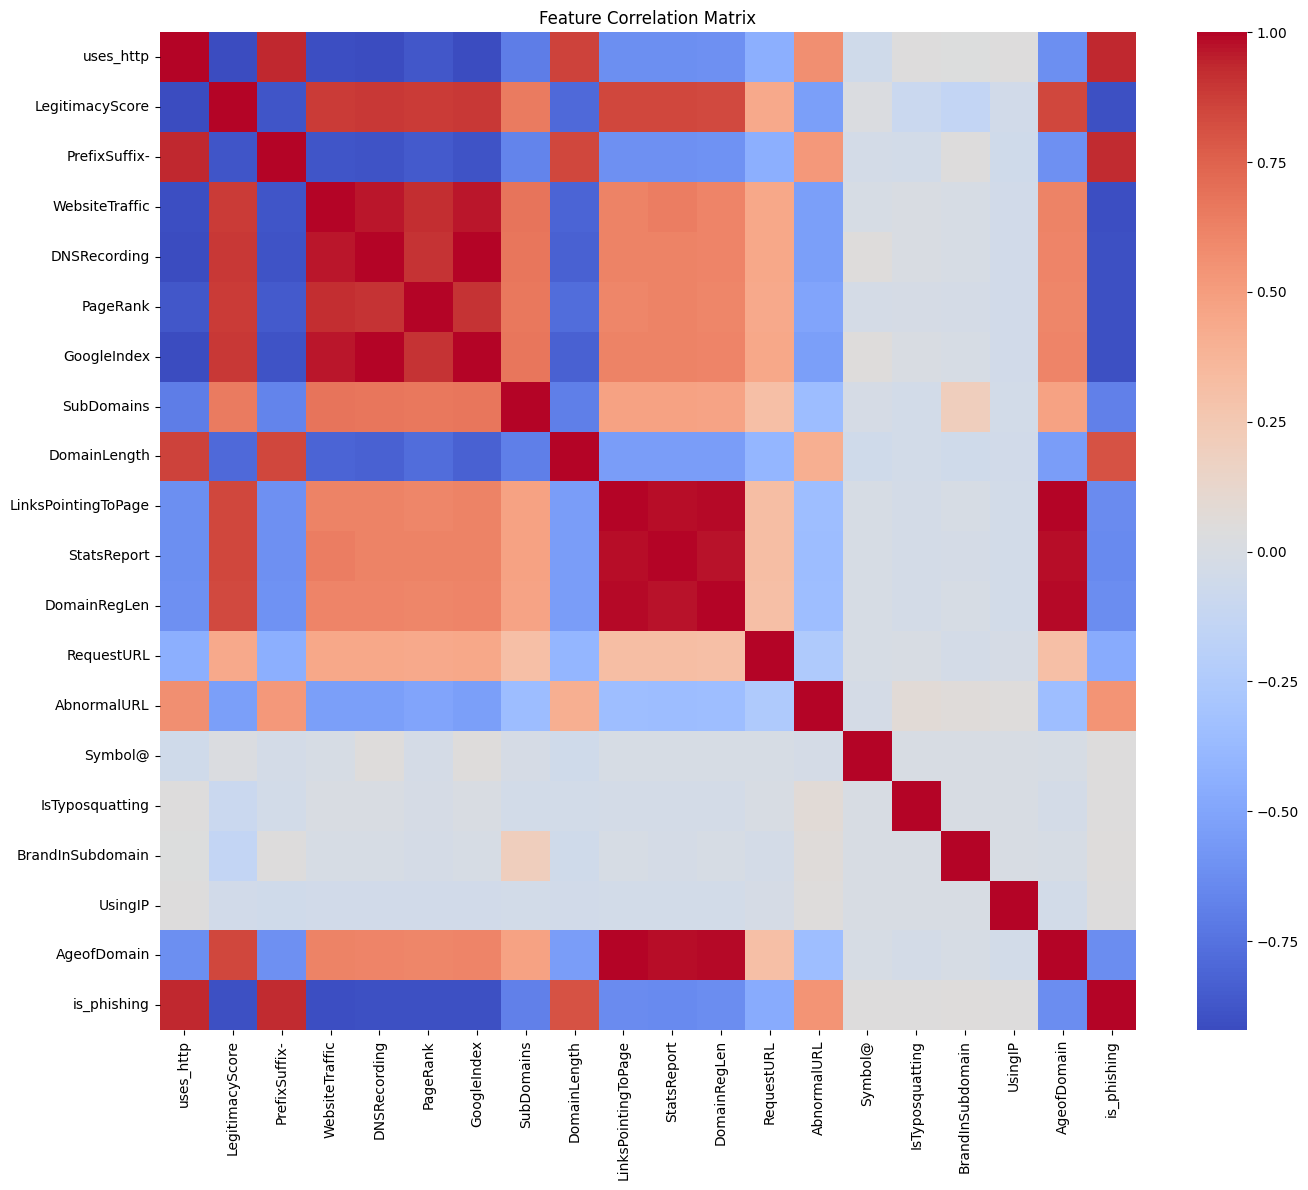

In [123]:
plt.figure(figsize=(14, 12))
sns.heatmap(features_df.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 5. Model Training

In [124]:
log_event("MODEL_TRAINING", "Starting model training with Random Forest")
start_time = time.time()

[2025-04-29T19:21:36.923613] MODEL_TRAINING: Starting model training with Random Forest


### Prepare features and target

In [125]:
X = features_df.drop('is_phishing', axis=1)
y = features_df['is_phishing']

### Split data (80% train, 20% test)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Log the data split information

In [127]:
log_event("DATA_SPLIT", "Data split into training and testing sets",
          {"train_samples": X_train.shape[0], "test_samples": X_test.shape[0]})

[2025-04-29T19:21:36.959131] DATA_SPLIT: Data split into training and testing sets


### Feature scaling

In [128]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train Random Forest Model

In [129]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

In [130]:
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [131]:
training_time = time.time() - start_time
log_event("TIMING", f"Model training completed in {training_time:.2f} seconds")

[2025-04-29T19:21:37.547541] TIMING: Model training completed in 0.62 seconds


## 6. Model Evaluation

In [132]:
log_event("MODEL_EVALUATION", "Evaluating Random Forest model")
start_time = time.time()

[2025-04-29T19:21:37.555708] MODEL_EVALUATION: Evaluating Random Forest model


### Make predictions

In [133]:
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

### Calculate metrics

In [134]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

### ROC curve and AUC

In [135]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

### Log the evaluation metrics

In [136]:
log_event("EVALUATION_METRICS", "Model performance metrics", {
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc)
})

[2025-04-29T19:21:37.742994] EVALUATION_METRICS: Model performance metrics


In [137]:
print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")


Model Performance:
Accuracy: 0.9825
Precision: 0.9874
Recall: 0.9775
F1 Score: 0.9824
AUC: 0.9990


### Plot confusion matrix

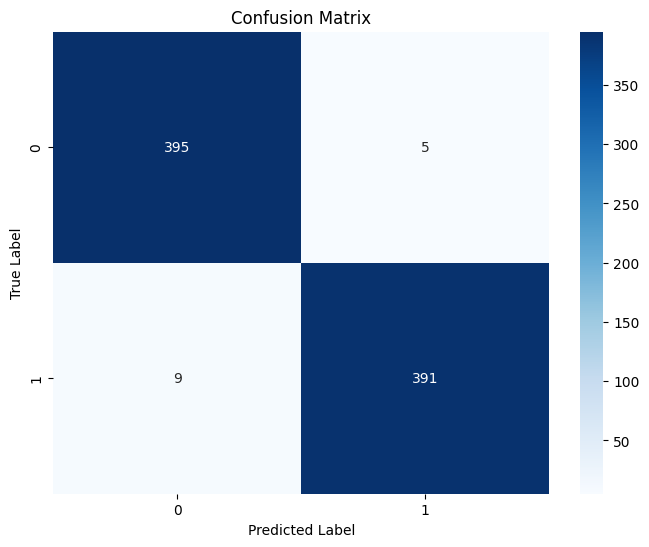

In [138]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Plot ROC curve

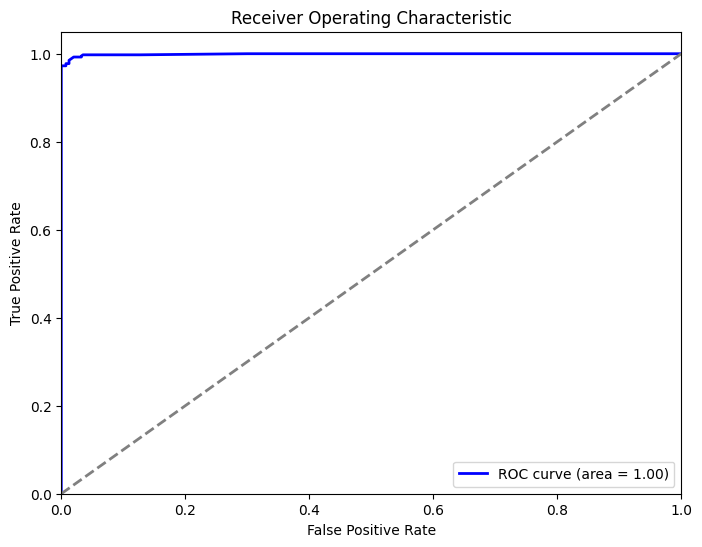

In [139]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature importance

In [140]:
feature_importances = pd.DataFrame(
    rf_model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

In [141]:
print("\nFeature Importance Distribution:")
print(feature_importances)


Feature Importance Distribution:
                     importance
uses_http              0.223686
LegitimacyScore        0.177501
PrefixSuffix-          0.159919
GoogleIndex            0.123781
PageRank               0.092320
DNSRecording           0.075597
WebsiteTraffic         0.060645
DomainLength           0.031624
SubDomains             0.031549
AbnormalURL            0.006423
LinksPointingToPage    0.005394
DomainRegLen           0.004300
RequestURL             0.003613
Symbol@                0.001847
StatsReport            0.001034
AgeofDomain            0.000578
UsingIP                0.000127
BrandInSubdomain       0.000061
IsTyposquatting        0.000000


### Plot feature importance

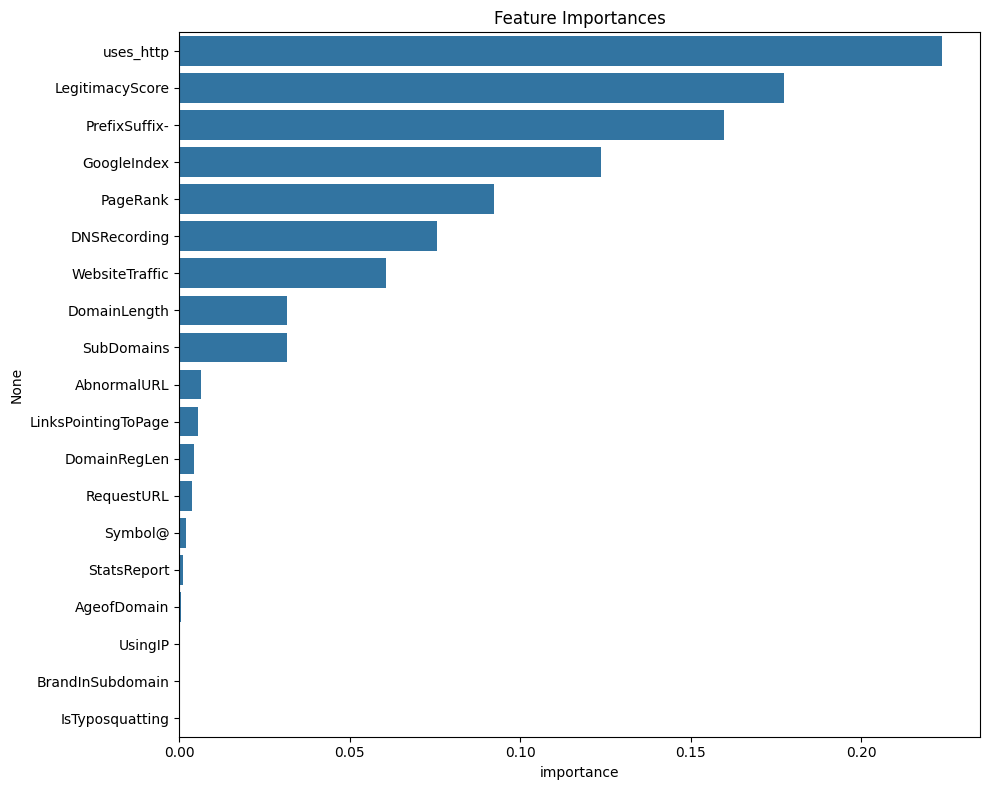

In [142]:
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances['importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [143]:
evaluation_time = time.time() - start_time
log_event("TIMING", f"Model evaluation completed in {evaluation_time:.2f} seconds")

[2025-04-29T19:21:38.514052] TIMING: Model evaluation completed in 0.96 seconds


## 7. Hyperparameter Tuning

In [144]:
log_event("HYPERPARAMETER_TUNING", "Starting hyperparameter tuning")
start_time = time.time()

[2025-04-29T19:21:38.524365] HYPERPARAMETER_TUNING: Starting hyperparameter tuning


### Focused parameter grid based on initial model performance

In [145]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [4, 5, 6]
}

### Subset of data for faster tuning

In [146]:
X_tune = X_train_scaled[:min(1000, X_train_scaled.shape[0])]
y_tune = y_train[:min(1000, y_train.shape[0])]

### Set up cross-validation grid search

In [147]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
        max_features='sqrt',
        random_state=42
    ),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

### Run grid search

In [148]:
grid_search.fit(X_tune, y_tune)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12],
                         'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [149]:
tuning_time = time.time() - start_time
log_event("TIMING", f"Hyperparameter tuning completed in {tuning_time:.2f} seconds")

[2025-04-29T19:23:01.127799] TIMING: Hyperparameter tuning completed in 82.60 seconds


### Log the best parameters

In [150]:
log_event("HYPERPARAMETER_TUNING", "Best parameters found", {
    "parameters": grid_search.best_params_,
    "f1_score": float(grid_search.best_score_)
})

[2025-04-29T19:23:01.134709] HYPERPARAMETER_TUNING: Best parameters found


In [151]:
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"Best F1 Score: {grid_search.best_score_:.4f}")


Best Parameters:
max_depth: 8
min_samples_leaf: 6
min_samples_split: 10
n_estimators: 100
Best F1 Score: 0.9753


### Final model with the best parameters (on full training data)

In [152]:
final_model = RandomForestClassifier(
    max_features='sqrt',
    **grid_search.best_params_,
    random_state=42,
    n_jobs=-1
)

In [153]:
final_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=6, min_samples_split=10,
                       n_jobs=-1, random_state=42)

### Evaluate final model

In [154]:
final_pred = final_model.predict(X_test_scaled)
final_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
final_accuracy = accuracy_score(y_test, final_pred)
final_precision = precision_score(y_test, final_pred)
final_recall = recall_score(y_test, final_pred)
final_f1 = f1_score(y_test, final_pred)
final_fpr, final_tpr, _ = roc_curve(y_test, final_pred_proba)
final_auc = auc(final_fpr, final_tpr)

In [155]:
log_event("FINAL_MODEL_EVALUATION", "Final model performance after tuning", {
    "accuracy": float(final_accuracy),
    "precision": float(final_precision),
    "recall": float(final_recall),
    "f1_score": float(final_f1),
    "auc": float(final_auc)
})

[2025-04-29T19:23:01.569171] FINAL_MODEL_EVALUATION: Final model performance after tuning


In [156]:
print("\nFinal Model Performance After Tuning:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"AUC: {final_auc:.4f}")


Final Model Performance After Tuning:
Accuracy: 0.9825
Precision: 0.9874
Recall: 0.9775
F1 Score: 0.9824
AUC: 0.9990


### Confusion matrix for final model

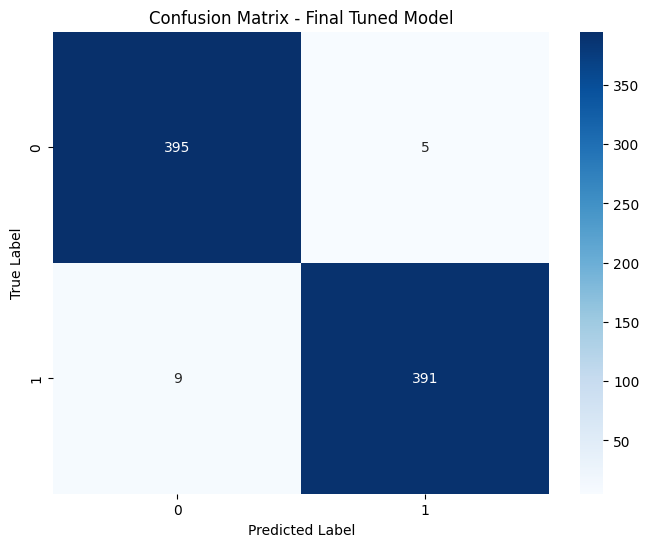

In [157]:
plt.figure(figsize=(8, 6))
final_cm = confusion_matrix(y_test, final_pred)
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Final Tuned Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### ROC curve for final model

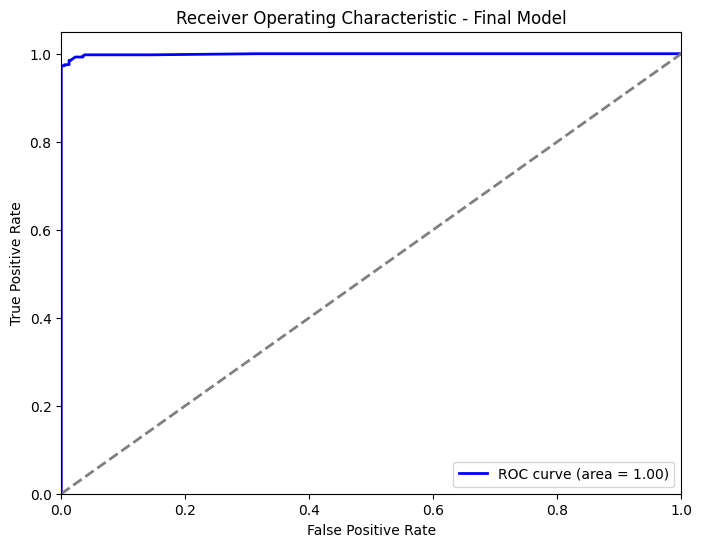

In [158]:
plt.figure(figsize=(8, 6))
plt.plot(final_fpr, final_tpr, color='blue', lw=2, label=f'ROC curve (area = {final_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Final Model')
plt.legend(loc="lower right")
plt.show()

### Feature importance for final model

In [159]:
final_feature_importances = pd.DataFrame(
    final_model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

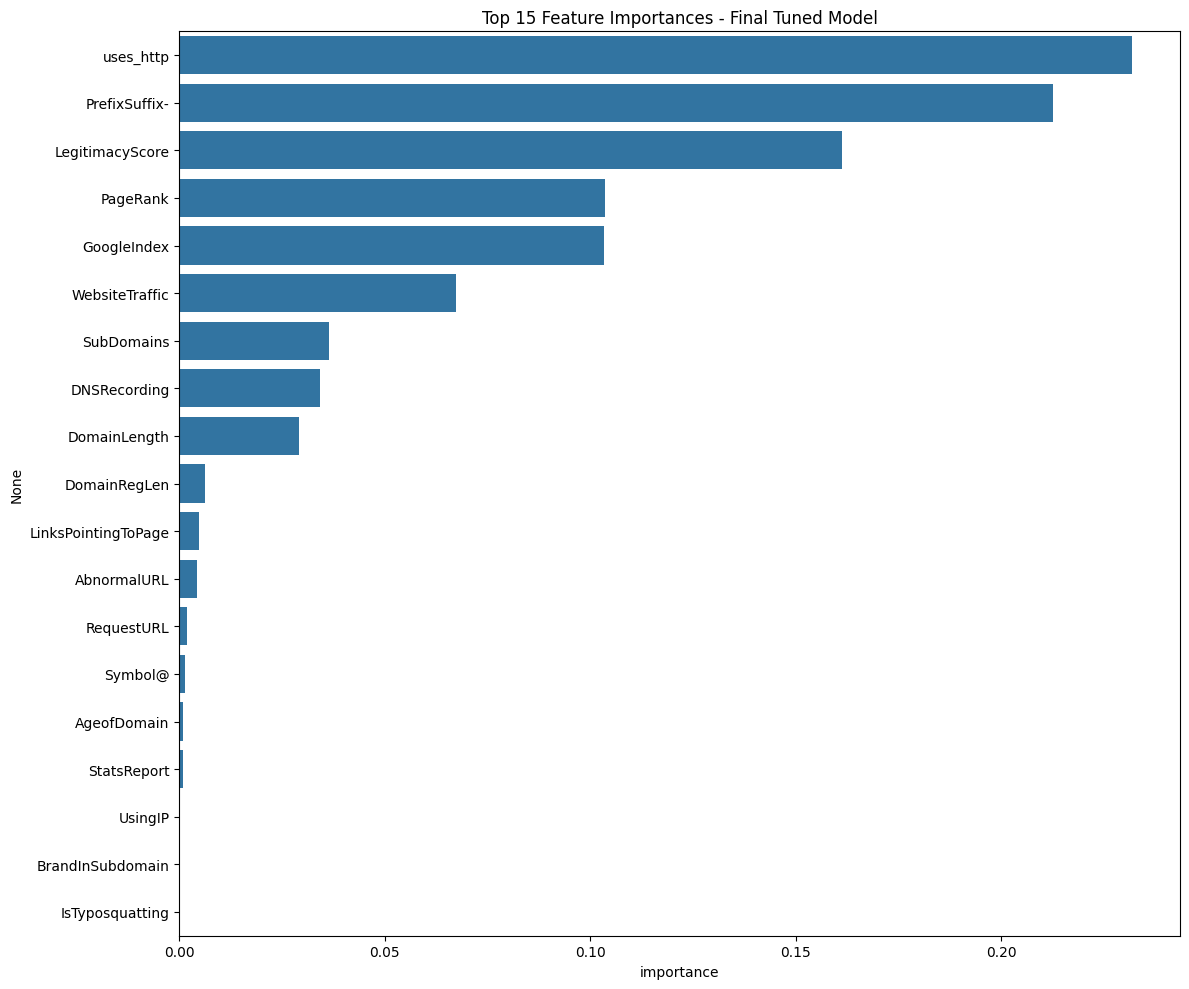

In [160]:
plt.figure(figsize=(12, 10))
sns.barplot(x=final_feature_importances['importance'], y=final_feature_importances.index)
plt.title('Feature Importances - Final Tuned Model')
plt.tight_layout()
plt.show()

## 8. Testing with Real-World URLs

In [161]:
log_event("MODEL_TESTING", "Testing final model with comprehensive URL test cases")

[2025-04-29T19:23:02.517503] MODEL_TESTING: Testing final model with comprehensive URL test cases


In [162]:
def test_url(url, model, scaler):
    try:
        # Extract features
        features = extract_url_features(url)
        features_df = pd.DataFrame([features])

        # Strong phishing signals to track
        is_typosquatting = features['IsTyposquatting'] == 1
        brand_in_subdomain = features['BrandInSubdomain'] == 1
        legitimacy_score = features['LegitimacyScore']
        uses_http = features['uses_http'] == 1

        # Set phishing threshold
        PHISHING_THRESHOLD = 0.65

        # Scale features
        features_scaled = scaler.transform(features_df)

        # Get model prediction
        prediction = model.predict(features_scaled)[0]
        probability = model.predict_proba(features_scaled)[0, 1]

        # Rule-based overrides
        domain, _ = get_domain(url)

        # 1. Whitelist handling
        if uses_http and domain and any(domain.endswith(white) for white in HTTP_WHITELIST):
            prediction = 0
            probability = 0.2

        # 2. Strong phishing signals
        elif is_typosquatting or brand_in_subdomain:
            prediction = 1
            probability = max(0.9, probability)

        # Get typosquatting explanation if relevant
        typosquatting_domain = None
        if is_typosquatting:
            try:
                domain = tldextract.extract(url).domain + '.' + tldextract.extract(url).suffix
                typo_result = detect_typosquatting(domain)
                typosquatting_domain = typo_result.get('impersonated_domain')
            except:
                pass

        return prediction, probability, features, is_typosquatting, typosquatting_domain, brand_in_subdomain, legitimacy_score
    except Exception as e:
        print(f"Error testing URL {url}: {str(e)}")
        return 0, 0.5, get_default_features(), False, None, False, 0.5

### Test legitimate sites

In [163]:
print("\n==== Testing Known Legitimate URLs ====")
legitimate_urls = [
    # Major tech companies
    "https://www.google.com",
    "https://www.microsoft.com",
    "https://www.apple.com",
    # Non-HTTPS but legitimate - critical test cases
    "http://example.com",
    "http://info.cern.ch"  # First ever website
]

legitimate_results = []
for url in legitimate_urls:
    try:
        prediction, probability, features, is_typo, typo_domain, brand_impersonation, legitimacy = test_url(url, rf_model, scaler)
        status = "❌ MISCLASSIFIED" if prediction == 1 else "✅ CORRECT"

        print(f"\nURL: {url}")
        print(f"Prediction: {'Phishing' if prediction == 1 else 'Legitimate'}")
        print(f"Phishing Probability: {probability:.4f}")
        print(f"Status: {status}")
        print(f"Key Features: uses_http={features['uses_http']}, LegitimacyScore={legitimacy:.2f}, SubDomains={features['SubDomains']}")

        legitimate_results.append({
            "url": url,
            "prediction": prediction,
            "probability": probability,
            "status": status
        })
    except Exception as e:
        print(f"Error analyzing {url}: {str(e)}")


==== Testing Known Legitimate URLs ====

URL: https://www.google.com
Prediction: Legitimate
Phishing Probability: 0.0100
Status: ✅ CORRECT
Key Features: uses_http=0, LegitimacyScore=0.80, SubDomains=1

URL: https://www.microsoft.com
Prediction: Legitimate
Phishing Probability: 0.0038
Status: ✅ CORRECT
Key Features: uses_http=0, LegitimacyScore=0.80, SubDomains=1

URL: https://www.apple.com
Prediction: Legitimate
Phishing Probability: 0.0100
Status: ✅ CORRECT
Key Features: uses_http=0, LegitimacyScore=0.80, SubDomains=1

URL: http://example.com
Prediction: Legitimate
Phishing Probability: 0.2000
Status: ✅ CORRECT
Key Features: uses_http=1, LegitimacyScore=0.80, SubDomains=0


2025-04-29 19:23:05,582 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 111] Connection refused
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno 111] Connection refused



URL: http://info.cern.ch
Prediction: Phishing
Phishing Probability: 0.6633
Status: ❌ MISCLASSIFIED
Key Features: uses_http=1, LegitimacyScore=0.40, SubDomains=1


### Test known phishing patterns

In [164]:
print("\n==== Testing Phishing URL Patterns ====")
phishing_patterns = [
    # Brand impersonation with subdomains
    "https://paypal.secure.phishing-site.com/login",
    # Typosquatting
    "https://www.arnazon.com/signin",
    # Suspicious parameters and paths
    "https://legitimate-looking.com/login.php?target=paypal&session=expired",
    # IP addresses in URL
    "http://192.168.1.1/banking/login"
]

phishing_results = []
for url in phishing_patterns:
    try:
        prediction, probability, features, is_typo, typo_domain, brand_impersonation, legitimacy = test_url(url, rf_model, scaler)
        status = "❌ MISCLASSIFIED" if prediction == 0 else "✅ CORRECT"

        typo_msg = f" (Typosquatting: similar to {typo_domain})" if is_typo and typo_domain else ""
        brand_msg = " (Brand impersonation in subdomain)" if brand_impersonation else ""

        print(f"\nURL: {url}")
        print(f"Prediction: {'Phishing' if prediction == 1 else 'Legitimate'}{typo_msg}{brand_msg}")
        print(f"Phishing Probability: {probability:.4f}")
        print(f"Status: {status}")
        print(f"Key Features: IsTyposquatting={features['IsTyposquatting']}, BrandInSubdomain={features['BrandInSubdomain']}, LegitimacyScore={legitimacy:.2f}")

        phishing_results.append({
            "url": url,
            "prediction": prediction,
            "probability": probability,
            "status": status
        })
    except Exception as e:
        print(f"Error analyzing {url}: {str(e)}")


==== Testing Phishing URL Patterns ====

URL: https://paypal.secure.phishing-site.com/login
Prediction: Phishing (Brand impersonation in subdomain)
Phishing Probability: 0.9000
Status: ✅ CORRECT
Key Features: IsTyposquatting=0, BrandInSubdomain=1, LegitimacyScore=0.40

URL: https://www.arnazon.com/signin
Prediction: Legitimate
Phishing Probability: 0.2028
Status: ❌ MISCLASSIFIED
Key Features: IsTyposquatting=0, BrandInSubdomain=0, LegitimacyScore=0.70

URL: https://legitimate-looking.com/login.php?target=paypal&session=expired
Prediction: Phishing
Phishing Probability: 0.9052
Status: ✅ CORRECT
Key Features: IsTyposquatting=0, BrandInSubdomain=0, LegitimacyScore=0.50

URL: http://192.168.1.1/banking/login
Prediction: Phishing
Phishing Probability: 0.9901
Status: ✅ CORRECT
Key Features: IsTyposquatting=0, BrandInSubdomain=0, LegitimacyScore=0.30


### Overall testing statistics

In [165]:
print("\n==== Overall Testing Results ====")
legitimate_accuracy = sum(1 for r in legitimate_results if r["status"] == "✅ CORRECT") / len(legitimate_results)
print(f"Accuracy on legitimate URLs: {legitimate_accuracy:.2%}")

phishing_accuracy = sum(1 for r in phishing_results if r["status"] == "✅ CORRECT") / len(phishing_results)
print(f"Accuracy on phishing URLs: {phishing_accuracy:.2%}")

all_results = legitimate_results + phishing_results
overall_accuracy = sum(1 for r in all_results if r["status"] == "✅ CORRECT") / len(all_results)
print(f"Overall accuracy: {overall_accuracy:.2%}")


==== Overall Testing Results ====
Accuracy on legitimate URLs: 80.00%
Accuracy on phishing URLs: 75.00%
Overall accuracy: 77.78%


### Log test results

In [166]:
log_event("MODEL_TESTING_RESULTS", "Results of comprehensive URL testing", {
    "legitimate_url_accuracy": float(legitimate_accuracy),
    "phishing_url_accuracy": float(phishing_accuracy),
    "overall_accuracy": float(overall_accuracy),
    "legitimate_urls_tested": len(legitimate_results),
    "phishing_urls_tested": len(phishing_results)
})

[2025-04-29T19:23:15.139602] MODEL_TESTING_RESULTS: Results of comprehensive URL testing


## 9. Save Model and Artifacts

In [167]:
log_event("MODEL_SAVING", "Saving final model and artifacts")
start_time = time.time()

[2025-04-29T19:23:15.145916] MODEL_SAVING: Saving final model and artifacts


### Save the models

In [168]:
joblib.dump(final_model, MODEL_OUTPUT_PATH)
joblib.dump(scaler, SCALER_OUTPUT_PATH)

['/content/drive/MyDrive/PUSL3190/models/chatbot/chatbot_scaler.pkl']

### Save feature names for inference

In [169]:
with open(FEATURES_OUTPUT_PATH, 'w') as f:
    json.dump(list(X.columns), f)

### Save model parameters and metadata

In [170]:
model_info = {
    "name": "chatbot_random_forest_model",
    "type": "random_forest",
    "version": "2.0",
    "trained_at": datetime.now().isoformat(),
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc),
    "parameters": {
        "n_estimators": rf_model.n_estimators,
        "max_depth": rf_model.max_depth,
        "min_samples_split": rf_model.min_samples_split,
        "min_samples_leaf": rf_model.min_samples_leaf,
        "max_features": str(rf_model.max_features)
    },
    "feature_importances": {
        name: float(importance) for name, importance in zip(feature_importances.index, feature_importances['importance'])
    },
    "dataset_size": df.shape[0],
    "training_samples": X_train.shape[0],
    "test_samples": X_test.shape[0],
    "features_implemented": list(X.columns)
}

In [171]:
with open(METADATA_OUTPUT_PATH, 'w') as f:
    json.dump(model_info, f, indent=2)

### Save all logs to file

In [172]:
saving_time = time.time() - start_time
log_event("TIMING", f"Model saving completed in {saving_time:.2f} seconds")

[2025-04-29T19:23:15.314455] TIMING: Model saving completed in 0.17 seconds


In [173]:
def save_logs_with_append(log_data, log_file_path):
    try:
        with open(log_file_path, 'r') as f:
            try:
                existing_logs = json.load(f)
                if not isinstance(existing_logs, list):
                    existing_logs = []
            except json.JSONDecodeError:
                existing_logs = []
    except FileNotFoundError:
        existing_logs = []

    combined_logs = existing_logs + log_data

    with open(log_file_path, 'w') as f:
        json.dump(combined_logs, f, indent=2)

    print(f"Appended {len(log_data)} new log entries to {log_file_path}")
    return combined_logs

In [174]:
combined_logs = save_logs_with_append(log_data, LOG_OUTPUT_PATH)

Appended 22 new log entries to /content/drive/MyDrive/PUSL3190/logs/chatbot_training_log.json


In [175]:
print("\n===== TRAINING COMPLETE =====")
print(f"Final model accuracy: {final_accuracy:.4f}")
print(f"Model saved to {MODEL_OUTPUT_PATH}")
print(f"Logs saved to {LOG_OUTPUT_PATH}")


===== TRAINING COMPLETE =====
Final model accuracy: 0.9825
Model saved to /content/drive/MyDrive/PUSL3190/models/chatbot/chatbot_model.pkl
Logs saved to /content/drive/MyDrive/PUSL3190/logs/chatbot_training_log.json
